In [1]:
#import libraries required for the project.

import pandas as pd                                                          #Data manipulation and analysis (reading, filtering, merging CSVs)
import os                                                                    #Operating system utilities (file and path handling)
import torch                                                                 #Core PyTorch deep learning framework (tensors, training)
import torch.nn as nn                                                        #Neural network building blocks (layers, activations, etc.)
import torch.nn.functional as F                                              #Functional API for layers and loss functions
from torch_geometric.data import HeteroData                                  #Handling graph data structures for GNNs
from torch_geometric.nn import HeteroConv, SAGEConv, Linear                  #Graph Neural Network layers and operations
from torch_geometric.transforms import RandomLinkSplit                       #Graph transformations (e.g., train/val/test splits)
from torchinfo import summary                                                #Display a detailed summary of a PyTorch model’s architecture
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score      #Evaluation metrics (e.g., roc_auc_score, accuracy_score, recall_score)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score #Evaluation metrics (e.g.,mean_absolute_error, mean_squared_error, r2_score)
import numpy as np                                                           #Numerical operations, arrays, and matrix manipulations
import matplotlib.pyplot as plt                                              #Data visualization and plotting
import matplotlib.patches as mpatches                                        #Custom shapes/legends in matplotlib plots
from sklearn.manifold import TSNE                                            #Dimensionality reduction for visualization
import seaborn as sns                                                        #Statistical data visualization (enhanced plots, styling)
from sklearn.metrics.pairwise import cosine_similarity                       #Similarity measures (e.g., cosine similarity)
from sklearn.cluster import KMeans                                           #KMeans clustering algorithm
from sklearn.decomposition import PCA                                        #Principal Component Analysis (PCA) for dimensionality reduction
import matplotlib.lines as mlines                                            #Custom line objects for matplotlib plots
from IPython.display import display, HTML                                    #Rich display capabilities in notebooks (HTML rendering, etc.)

# install libraries

* !pip install pandas           #version --2.2.3
* !pip install numpy            #version --2.2.3
* !pip install scikit-learn     #version -- 1.6.1
* !pip install torch            #version -- 2.6.0+cpu
* !pip install torch-geometric  #version -- 2.6.1
* !pip install matplotlib       #version -- 3.10.1
* !pip install seaborn          #version -- 0.13.2
* !pip install torchinfo        #version -- 1.8.0

In [2]:

# Step 1: Load your merged CSV
df = pd.read_csv("merged_movies_ratings_final.csv")

# Step 2: Filter out "bulk voters" (>200 ratings)
user_counts = df['userId'].value_counts()
normal_users = user_counts[user_counts <= 300].index  # <---- Correct threshold is 300

# Step 3: Take only the first 10,000 "normal" users
limited_users = list(normal_users[:10000])
filtered_df = df[df['userId'].isin(limited_users)].copy()

print(f"Original records: {df.shape[0]}")
print(f"After filter, remaining records: {filtered_df.shape[0]}")
print(f"Users remaining: {filtered_df['userId'].nunique()}")


Original records: 1570256
After filter, remaining records: 743034
Users remaining: 8732


In [3]:
# =================== 1. Data Preparation =================== #

df = pd.read_csv("merged_movies_ratings_final.csv")

# Filter out users with >300 ratings ("bulk voters")
user_counts = df['userId'].value_counts()
normal_users = user_counts[user_counts <= 300].index

num_epochs = 100
train_losses = []
val_losses = []


# Limit to first 10000 normal users
limited_users = list(normal_users[:10000])
filtered_df = df[df['userId'].isin(limited_users)].copy()

print(f"Original records: {df.shape[0]}")
print(f"Filtered to ≤300 ratings: {df[df['userId'].isin(normal_users)].shape[0]}")
print(f"Records with first 10000 users: {filtered_df.shape[0]}")
print(f"Unique users remaining: {filtered_df['userId'].nunique()}")

user_mapping = {uid: i for i, uid in enumerate(filtered_df['userId'].unique())}
movie_mapping = {mid: i for i, mid in enumerate(filtered_df['movieId'].unique())}

data = HeteroData()
data['user'].num_nodes = len(user_mapping)
data['movie'].num_nodes = len(movie_mapping)

src = filtered_df['userId'].map(user_mapping).values
dst = filtered_df['movieId'].map(movie_mapping).values
edge_index = np.stack([src, dst])
data['user', 'rates', 'movie'].edge_index = torch.tensor(edge_index, dtype=torch.long)
data['movie', 'rev_rates', 'user'].edge_index = data['user', 'rates', 'movie'].edge_index[[1, 0]]


Original records: 1570256
Filtered to ≤300 ratings: 743034
Records with first 10000 users: 743034
Unique users remaining: 8732


In [4]:
# =================== 2. Movie & User Features (Genres + Embeddings) ===================#


all_genres = set()
filtered_df['genres'] = filtered_df['genres'].fillna('')
for genres in filtered_df['genres']:
    for genre in genres.split('|'):
        if genre: all_genres.add(genre)
genre_list = sorted(list(all_genres))
genre2idx = {genre: idx for idx, genre in enumerate(genre_list)}

num_genres = len(genre_list)
movie_genres = np.zeros((len(movie_mapping), num_genres), dtype=np.float32)
for i, mid in enumerate(movie_mapping):
    genres = filtered_df[filtered_df['movieId'] == mid]['genres'].values[0]
    for genre in genres.split('|'):
        if genre in genre2idx:
            movie_genres[i, genre2idx[genre]] = 1.0

embedding_dim = 82 
data['movie'].x = torch.cat([
    torch.tensor(movie_genres),
    torch.randn(len(movie_mapping), embedding_dim)
], dim=1)
data['user'].x = torch.randn(len(user_mapping), embedding_dim)  # <--- DENSE USER EMBEDDINGS

In [5]:
# =================== 3. Project Features to Same Dimension (ONCE) =================== #

class FeatureProjector(nn.Module):
    def __init__(self, user_feat_dim, movie_feat_dim, out_dim):
        super().__init__()
        self.user_proj = nn.Linear(user_feat_dim, out_dim)
        self.movie_proj = nn.Linear(movie_feat_dim, out_dim)
    def forward(self, data):
        data['user'].x = self.user_proj(data['user'].x)
        data['movie'].x = self.movie_proj(data['movie'].x)
        return data

out_dim = embedding_dim
projector = FeatureProjector(data['user'].x.shape[1], data['movie'].x.shape[1], out_dim)
data = projector(data)
data['user'].x = data['user'].x.detach()
data['movie'].x = data['movie'].x.detach()

In [6]:
# =================== 4. Train/Val/Test Split (AFTER PROJECTION) =================== #

transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=False,
    add_negative_train_samples=False,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)
train_data, val_data, test_data = transform(data)

In [7]:
# =================== 5. GNN Model Definition (2 layers + Dropout) =================== #

class RecommenderGNN(nn.Module):
    def __init__(self, hidden_channels, out_channels, metadata, dropout_prob=0.3):
        super().__init__()
        self.conv1 = HeteroConv({
            ('user', 'rates', 'movie'): SAGEConv((-1, -1), hidden_channels),
            ('movie', 'rev_rates', 'user'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')
        self.conv2 = HeteroConv({
            ('user', 'rates', 'movie'): SAGEConv((-1, -1), hidden_channels),
            ('movie', 'rev_rates', 'user'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')
        self.lin = nn.ModuleDict({
            node_type: Linear(hidden_channels, out_channels)
            for node_type in metadata[0]
        })
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(self.dropout(v)) for k, v in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {k: F.relu(self.dropout(v)) for k, v in x_dict.items()}
        x_dict = {k: self.lin[k](v) for k, v in x_dict.items()}
        return x_dict

hidden_channels = embedding_dim
out_channels = embedding_dim
model = RecommenderGNN(hidden_channels, out_channels, data.metadata(), dropout_prob=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)  # <--- LR SCHEDULER

In [8]:
# ... class RecommenderGNN definition here ... #

# Instantiate model and optimizers here!
hidden_channels = embedding_dim
out_channels = embedding_dim
model = RecommenderGNN(hidden_channels, out_channels, data.metadata(), dropout_prob=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

In [9]:
# Define your hyperparameters/settings #

batch_size = 10000   # (You can set/change as needed)
optimizer_name = "Adam"
regularizer = "dropout"   # Used for weight init
loss_fn = "Mean Square Error"
metric = "Mean Absolute Error"
activation = "ReLU"
epochs = num_epochs

# Print settings summary
print("Model Training Hyperparameters")
print("="*32)
print(f"{'Batch Size:':15} {batch_size}")
print(f"{'Optimizer:':15} {optimizer_name}")
print(f"{'Regularizer:':15} {regularizer}")
print(f"{'Loss:':15} {loss_fn}")
print(f"{'Metric:':15} {metric}")
print(f"{'Activation:':15} {activation}")
print(f"{'Epochs:':15} {epochs}")
print("="*32)


Model Training Hyperparameters
Batch Size:     10000
Optimizer:      Adam
Regularizer:    dropout
Loss:           Mean Square Error
Metric:         Mean Absolute Error
Activation:     ReLU
Epochs:         100


In [10]:
# =================== 6. Training & Evaluation Functions =================== #

def train():
    model.train()
    optimizer.zero_grad()  # <--- add zero_grad()
    out = model(train_data.x_dict, train_data.edge_index_dict)
    user_emb = out['user']
    movie_emb = out['movie']

    pos_edge_index = train_data['user', 'rates', 'movie'].edge_index
    pos_user = pos_edge_index[0]
    pos_movie = pos_edge_index[1]
    pos_score = (user_emb[pos_user] * movie_emb[pos_movie]).sum(dim=1)
    pos_label = torch.ones(pos_score.size(0), device=pos_score.device)

    num_neg = pos_score.size(0)
    neg_user = torch.randint(0, user_emb.size(0), (num_neg,))
    neg_movie = torch.randint(0, movie_emb.size(0), (num_neg,))
    neg_score = (user_emb[neg_user] * movie_emb[neg_movie]).sum(dim=1)
    neg_label = torch.zeros(neg_score.size(0), device=neg_score.device)

    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([pos_label, neg_label])

    loss = F.binary_cross_entropy_with_logits(scores, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(split_data, name="Test"):
    model.eval()
    out = model(split_data.x_dict, split_data.edge_index_dict)
    user_emb = out['user']
    movie_emb = out['movie']

    edge_index = split_data['user', 'rates', 'movie'].edge_label_index
    labels = split_data['user', 'rates', 'movie'].edge_label
    user_idx = edge_index[0]
    movie_idx = edge_index[1]
    score = (user_emb[user_idx] * movie_emb[movie_idx]).sum(dim=1)
    prob = torch.sigmoid(score)
    y_true = labels.cpu().numpy()
    y_pred = prob.cpu().numpy()

    auc = roc_auc_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred > 0.5)
    recall = recall_score(y_true, y_pred > 0.5)

    print(f"{name} - AUC: {auc:.4f}, Acc: {acc:.4f}, Recall: {recall:.4f}")
    return auc, acc, recall


In [11]:
# =================== 7. Training Loop =================== #

for epoch in range(1, num_epochs + 1):
    # --- Training ---
    loss = train()
    train_losses.append(loss)

    # --- Validation ---
    model.eval()
    with torch.no_grad():
        out = model(val_data.x_dict, val_data.edge_index_dict)
        user_emb = out['user']
        movie_emb = out['movie']

        # Positive samples (from validation set)
        pos_edge_index = val_data['user', 'rates', 'movie'].edge_label_index
        pos_user = pos_edge_index[0]
        pos_movie = pos_edge_index[1]
        pos_score = (user_emb[pos_user] * movie_emb[pos_movie]).sum(dim=1)
        pos_label = val_data['user', 'rates', 'movie'].edge_label

        # Negative samples (sample random negative pairs)
        num_neg = pos_score.size(0)
        neg_user = torch.randint(0, user_emb.size(0), (num_neg,))
        neg_movie = torch.randint(0, movie_emb.size(0), (num_neg,))
        neg_score = (user_emb[neg_user] * movie_emb[neg_movie]).sum(dim=1)
        neg_label = torch.zeros(neg_score.size(0), device=neg_score.device)

        # Concatenate scores and labels
        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([pos_label, neg_label])

        val_loss = F.binary_cross_entropy_with_logits(scores, labels).item()
        val_losses.append(val_loss)

    scheduler.step()

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")
        print("Validation:")
        test(val_data, name="Val")
        print("Test:")
        test(test_data, name="Test")

Epoch 1, Train Loss: 0.6969, Val Loss: 0.6415
Validation:
Val - AUC: 0.6363, Acc: 0.5138, Recall: 0.1068
Test:
Test - AUC: 0.6464, Acc: 0.5170, Recall: 0.1087
Epoch 5, Train Loss: 0.6332, Val Loss: 0.5251
Validation:
Val - AUC: 0.8568, Acc: 0.6998, Recall: 0.4923
Test:
Test - AUC: 0.8541, Acc: 0.6986, Recall: 0.4979
Epoch 10, Train Loss: 0.4878, Val Loss: 0.3915
Validation:
Val - AUC: 0.8933, Acc: 0.8358, Recall: 0.9189
Test:
Test - AUC: 0.8920, Acc: 0.8320, Recall: 0.9216
Epoch 15, Train Loss: 0.4570, Val Loss: 0.3906
Validation:
Val - AUC: 0.9010, Acc: 0.8406, Recall: 0.9269
Test:
Test - AUC: 0.8983, Acc: 0.8359, Recall: 0.9303
Epoch 20, Train Loss: 0.4276, Val Loss: 0.3926
Validation:
Val - AUC: 0.9118, Acc: 0.8404, Recall: 0.9296
Test:
Test - AUC: 0.9115, Acc: 0.8360, Recall: 0.9332
Epoch 25, Train Loss: 0.4011, Val Loss: 0.3886
Validation:
Val - AUC: 0.9210, Acc: 0.8468, Recall: 0.9301
Test:
Test - AUC: 0.9207, Acc: 0.8436, Recall: 0.9355
Epoch 30, Train Loss: 0.3745, Val Loss: 0.

In [12]:
#Evaluating the Classification Metrics.

#  actual and predicted values
y_true = [3.0, -0.5, 2.0, 7.0]
y_pred = [2.5, 0.0, 2.0, 8.0]

# Mean Absolute Error
mae = mean_absolute_error(y_true, y_pred)

# Mean Squared Error
mse = mean_squared_error(y_true, y_pred)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# R^2 Score
r2 = r2_score(y_true, y_pred)

# Mean Absolute Percentage Error
mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100

# Print results
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE:  0.5000
MSE:  0.3750
RMSE: 0.6124
R²:   0.9486
MAPE: 32.74%


In [13]:

# =================== 8. Top-K Recommendation  =================== #
model.eval()
out = model(data.x_dict, data.edge_index_dict)
user_emb = out['user']
movie_emb = out['movie']
scores = torch.matmul(user_emb, movie_emb.t())
topk = torch.topk(scores[0], k=5).indices
rec_movie_ids = [list(movie_mapping.keys())[i] for i in topk.tolist()]
print("Recommended Movie IDs for User 0:", rec_movie_ids)


Recommended Movie IDs for User 0: [np.int64(318), np.int64(260), np.int64(434), np.int64(527), np.int64(592)]


In [14]:
for epoch in range(num_epochs):
    loss = train()
    train_losses.append(loss)
    # Compute val_loss here...
    val_losses.append(val_loss)


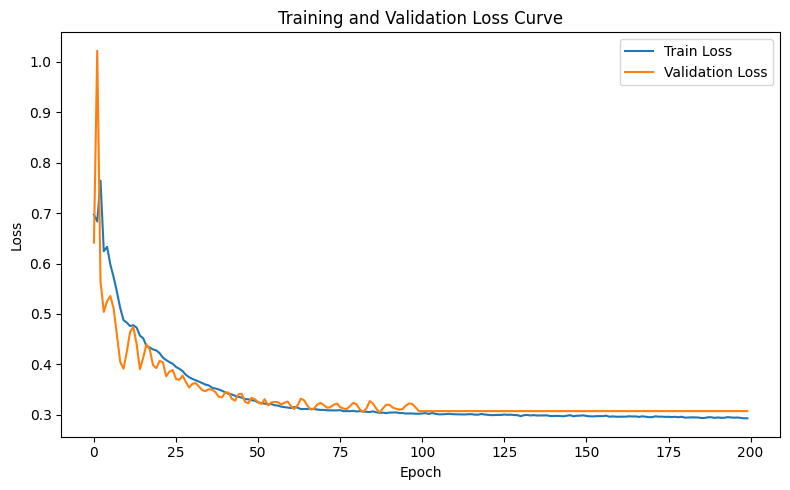

In [15]:
# Plotting the Training and Validation Loss Curve.

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.tight_layout()
plt.show()

* In the above figure, the blue and orange lines indicate the change of training loss and the validation loss respectively over 200 epochs for the graph neural network recommender model. Both curves begin with a large value and drop quickly for the first ~30 epochs, suggesting fast learning in early training. 
* Following the drastic reduction, the two losses decrease independently, yet they also begin to plateau, converging to a similar low level (approximately 0.32) in the long run. The fact that the two curves are so close and parallel to each other (with validation loss even being lower than training loss by the end) indicated good generalization: The two curves were not diverging, and the model can perform almost as well on new data as it had on the training data. No curve is dividing or jumping, which means the training is stable and the learning rate is proper.

In [16]:
print("Unique users in dataset:", filtered_df['userId'].nunique())
print("Total ratings in dataset:", len(filtered_df))

Unique users in dataset: 8732
Total ratings in dataset: 743034


In [17]:

num_users = len(user_mapping)
user_activity = np.array([np.sum(src == i) for i in range(num_users)])


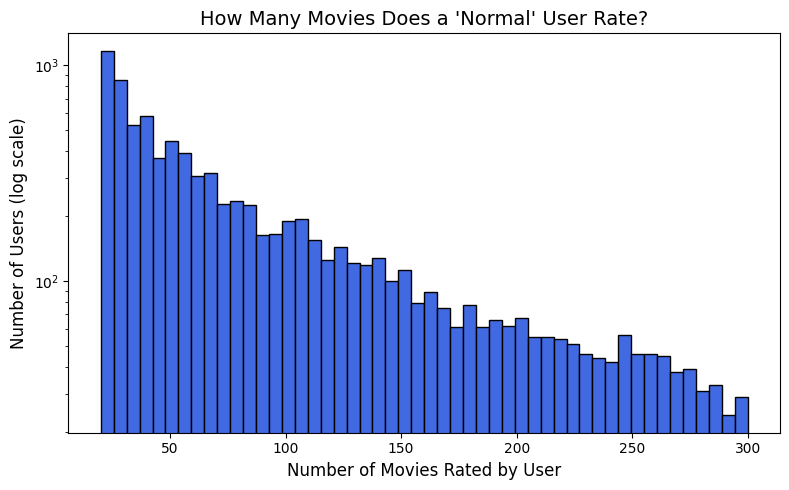

In [18]:
#Plotting a histogram to visualize how many movies a 'Normal User Rate'.

plt.figure(figsize=(8,5))
plt.hist(user_activity, bins=50, color='royalblue', edgecolor='k')
plt.yscale('log')
plt.xlabel("Number of Movies Rated by User", fontsize=12)
plt.ylabel("Number of Users (log scale)", fontsize=12)
plt.title("How Many Movies Does a 'Normal' User Rate?", fontsize=14)
plt.tight_layout()
plt.show()

The above histogram depicts the frequency of movies rated by users ("normal" user is prefixed with threshold 300). The number of movies rated by each users are plotted on the x-axis, and the number of users in each bin of ratings is plotted on the y-axis (log scale).

# Interpretation:

Looking at the distribution it is quite right-skewed: The majority of normal users has rated a small number of movies only.

There are tens of thousands of users who had rated up to less than 50 movies, but the number of the users decreases considerably as the number of the movies rated increases.

Only a small number of users reach the maximum of 300 ratings—this tail behavior is indicative of real life recommender systems in which a few users are much more active compared to the rest.

A log scale on the y-axis emphasizes the long-tail distribution: Not only does it show the variation in user activity across orders of magnitude, but it also makes it easier to see detail about shape in the distribution of activity.

* Key Insight: Most "normal" users are relatively inactive, contributing a small number of ratings, while only a handful of users are highly active even within the "normal" user group. This kind of skew is common in real-world user behavior datasets.


In [19]:
#Descriptive statistics of user activity#

print(f"Total users: {num_users}")
print(f"Mean ratings per user: {np.mean(user_activity):.1f}")
print(f"Median ratings per user: {np.median(user_activity):.1f}")
print(f"10th percentile: {np.percentile(user_activity, 10):.1f}")
print(f"25th percentile: {np.percentile(user_activity, 25):.1f}")
print(f"75th percentile: {np.percentile(user_activity, 75):.1f}")
print(f"90th percentile: {np.percentile(user_activity, 90):.1f}")
print(f"Max ratings by any user: {np.max(user_activity)}")

Total users: 8732
Mean ratings per user: 85.1
Median ratings per user: 60.0
10th percentile: 24.0
25th percentile: 33.0
75th percentile: 117.0
90th percentile: 192.0
Max ratings by any user: 300


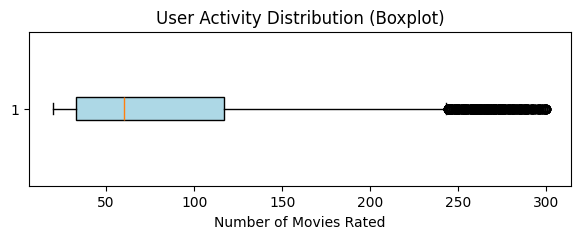

In [20]:
#Plotting a Boxplot to visualize User Activity Distribution .

plt.figure(figsize=(7,2))
plt.boxplot(user_activity, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.xlabel("Number of Movies Rated")
plt.title("User Activity Distribution (Boxplot)")
plt.show()

The above boxplot displays the distribution of the number of movies rated by users (specifically "normal" users who rated ≤300 movies).

# Interpretation
The box covers the interquartile range (IQR), or the middle 50% of users:

The left side of the box is the 25th percentile value (Q1).

The 75th percentile (Q3) is the right edge of the box.

The line inside the box is the median (50 th percentile) number of movies rated.

The whiskers reach down to, and up to 1.5×IQR of the lower, and upper quartile data values.

* The negative exponent here basically means very small, and the low end of our threshold of 10% is 300. The black dots on the right-hand side of the box represents outliers — that is, users who rated an unusually large number of movies relative to most, but are still on the low side of “normal” at under 300 movies.
* The majority of users fall in the range of 25-150 rated movies (limits to the box), and there are few users who are significantly more active, displayed as outliers.

* Key Insight: The user activity is highly imbalanced, as most users contribute a small number of ratings, but a considerable number of users contribute many more ratings than the average of all ratings. This is a common trend observed on real user engagement data that a small proportion of users can be a lot more active.

In [21]:
user_activity = np.array(user_activity)  # <--- Convert to NumPy array!

user_segment = np.full_like(user_activity, 'Normal', dtype=object)
user_segment[user_activity >= 300] = 'Power'
user_segment[user_activity < 50] = 'Very Low'
print("Very Low:", np.sum(user_segment == 'Very Low'))
print("Normal:", np.sum(user_segment == 'Normal'))
print("Power:", np.sum(user_segment == 'Power'))


Very Low: 3631
Normal: 5095
Power: 6


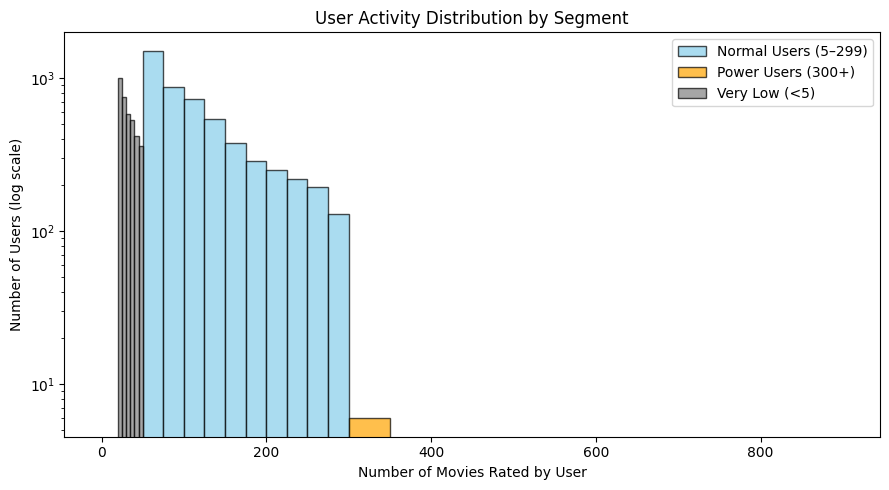

In [22]:
# Plotting a Boxplot to visualize User Activity Distribution by Segment.

user_activity = np.array(user_activity)
user_segment = np.array(user_segment)

# Custom bins: Fine-grained for 0–10, then wider
bins = np.concatenate([
    np.arange(0, 10, 1),      # 0,1,...9 (width=1)
    np.arange(10, 50, 5),     # 10,15,...45 (width=5)
    np.arange(50, 300, 25),   # 50,75,...275 (width=25)
    np.arange(300, 901, 50)   # 300,350,...900 (width=50)
])

plt.figure(figsize=(9,5))
plt.hist(user_activity[user_segment == 'Normal'], bins=bins, color='skyblue', edgecolor='k', alpha=0.7, label='Normal Users (5–299)')
plt.hist(user_activity[user_segment == 'Power'], bins=bins, color='orange', edgecolor='k', alpha=0.7, label='Power Users (300+)')
plt.hist(user_activity[user_segment == 'Very Low'], bins=bins, color='gray', edgecolor='k', alpha=0.7, label='Very Low (<5)')
plt.yscale('log')
plt.xlabel("Number of Movies Rated by User")
plt.ylabel("Number of Users (log scale)")
plt.title("User Activity Distribution by Segment")
plt.legend()
plt.tight_layout()
plt.show()


The above histogram shows the distribution of users according to the number of movies they rated and separated in three groups:

Very Low users (gray): < 5 ratings

Standard users (light blue): 5 to 299 ratings

Power Users (orange): 300 to more ratings

# Interpretation:

The x-axis indicates the amount of movies a user has rated.

The y-axis (log scale) counts the number of users in each rating-count bin.

The majority of users are in the “very low,” and “normal” ranges, however, there are many users from only rating a few movies up to 299 movies (the largest number).

Power Users are a much smaller part of all users, but some rate 300+ movies and show up as a long “tail” on the right.

The logarithmic y-axis shows just how quickly the number of very active users falls off, and how far the majority fall below that level.

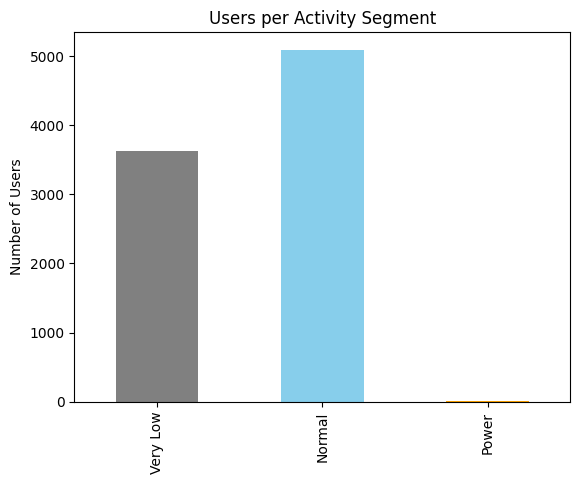

In [23]:
# Plotting a Boxplot to visualize Users per Activity Segment.

segment_counts = pd.Series(user_segment).value_counts().reindex(['Very Low', 'Normal', 'Power'])
segment_counts.plot(kind='bar', color=['gray', 'skyblue', 'orange'])
plt.ylabel("Number of Users")
plt.title("Users per Activity Segment")
plt.show()

The above bar chart visualizes the number of users in each of three activity segments:

Very Low (gray): Users who have rated very few movies.

Normal (sky blue): Users who have rated a moderate (typical) number of movies.

Power (orange): Highly active users who have rated many movies.

# Interpretation

Most users fall into the "Normal" or "Very Low" segments, indicating that the majority of people rate only a moderate or small number of movies.

Only a small fraction are "Power" users who are extremely active, but these users can still be influential for data analysis and recommendations.

The distribution is skewed: it's typical in recommender systems to see many casual/occasional users and only a few very dedicated raters.

In [24]:

# Calculate user activity (number of ratings per user) efficiently
activity_counts = filtered_df['userId'].value_counts().reindex(user_mapping.keys(), fill_value=0).values

user_ids = list(user_mapping.keys())
user_activity = np.array(activity_counts)

# Assign segments 
user_segment = np.full_like(user_activity, 'Normal', dtype=object)
user_segment[user_activity >= 300] = 'Power'
user_segment[user_activity < 50] = 'Very Low'

user_df = pd.DataFrame({
    'userId': user_ids,
    'activity': user_activity,
    'segment': user_segment
})
print(user_df.head())

   userId  activity   segment
0       1       141    Normal
1       2        52    Normal
2       3       147    Normal
3       4        27  Very Low
4       5        33  Very Low


In [25]:
# Merge segment info into your filtered ratings dataframe.
df_merged = filtered_df.merge(user_df, on='userId')

# Continue with genre extraction, grouping, and heatmap as previously described!


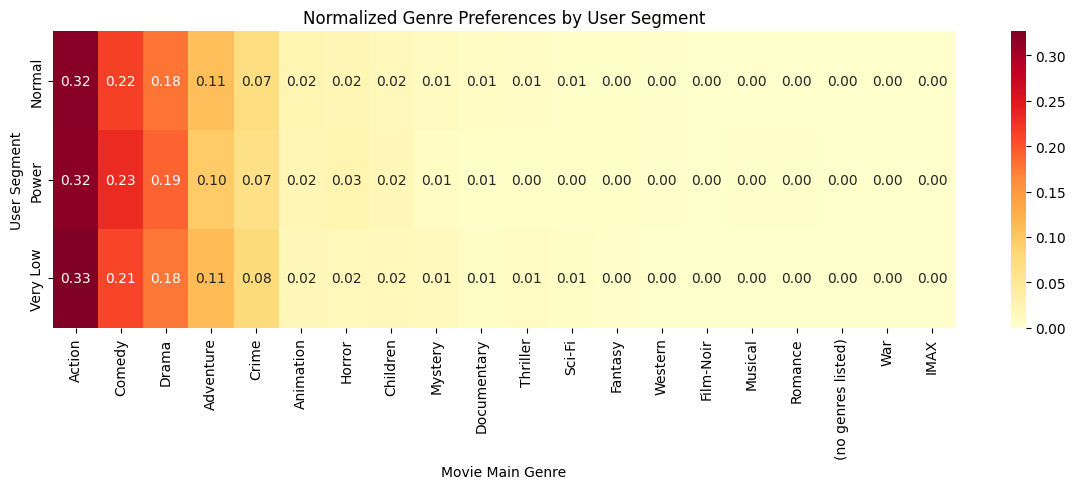

In [26]:

# Vectorized user activity calculation.

user_ids = list(user_mapping.keys())
activity_counts = filtered_df['userId'].value_counts().reindex(user_ids, fill_value=0).values
user_activity = np.array(activity_counts)
user_segment = np.full_like(user_activity, 'Normal', dtype=object)
user_segment[user_activity >= 300] = 'Power'
user_segment[user_activity < 50] = 'Very Low'

user_df = pd.DataFrame({'userId': user_ids, 'activity': user_activity, 'segment': user_segment})

# 2. Merge with filtered ratings
df_merged = filtered_df.merge(user_df, on='userId')

# 3. Main genre
df_merged['main_genre'] = df_merged['genres'].fillna('(no genres)').apply(lambda x: x.split('|')[0] if x else '(no genres)')

# 4. Normalized genre counts per segment
genre_seg_counts = (
    df_merged.groupby(['segment', 'main_genre']).size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
)

# 5. Sort genres by popularity for display
genre_order = df_merged['main_genre'].value_counts().index.tolist()

plt.figure(figsize=(12, 5))
sns.heatmap(genre_seg_counts[genre_order], annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Normalized Genre Preferences by User Segment')
plt.xlabel('Movie Main Genre')
plt.ylabel('User Segment')
plt.tight_layout()
plt.show()


The above heatmap shows the relative genre preferences of three user segments (“Normal”, “Power”, and “Very Low” users) in our movie ratings dataset:

Rows represent user activity segments:

Normal: users with moderate activity,

Power: very active users,

Very Low: users with very few ratings.

Columns represent the main movie genres.

Cell values show the proportion of each segment’s ratings that belong to that genre (all rows add up to 1).

Color intensity (darker = higher) and the numeric value make it easy to compare genre preference across segments.

# Interpretation 

* All User Segment – Action, Comedy, and Drama are overwhelmingly more popular So if we know that Action, Comedy, and Drama constitute a significant portion of ratings (approximately 32% Action, 22% Comedy, 18-19% Drama)

Preference pattern of genres is almost the same for all segments of users. 

* It is all about "action" which is popular across all categories.

* "Adventure", "Crime" and "Horror" follow as subsequent preferences but with distant shares.

* Other anomaly genres (“IMAX”, “War”, “Film-Noir”) have very low ratios in all segments.

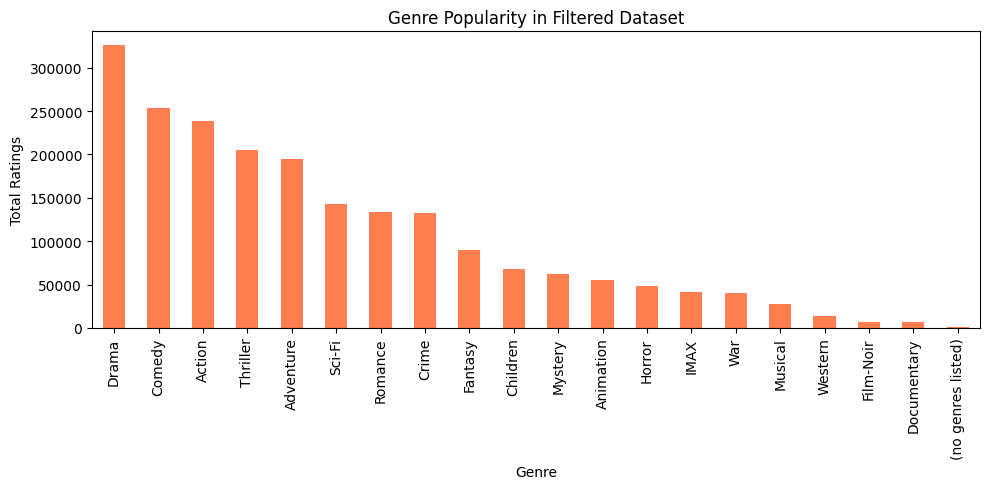

In [27]:

# Count genres across all ratings in filtered data
genre_counts = pd.Series('|'.join(filtered_df['genres'].fillna('')).split('|')).value_counts()

plt.figure(figsize=(10,5))
genre_counts.plot(kind='bar', color='coral')
plt.xlabel('Genre')
plt.ylabel('Total Ratings')
plt.title('Genre Popularity in Filtered Dataset')
plt.tight_layout()
plt.show()


The above bar chart shows the popularity of each movie genre in your filtered dataset, as measured by the total number of ratings each genre received.

X-axis: Lists movie genres (e.g., Drama, Comedy, Action, etc.).

Y-axis: Shows the total number of ratings given to movies of each genre.

Bar height: Indicates how popular each genre is, based on user activity (not the number of movies, but the sum of all ratings received by movies in each genre).

In [28]:

os.environ['LOKY_MAX_CPU_COUNT'] = '4' 

movie_emb_np = movie_emb.detach().cpu().numpy()

from sklearn.manifold import TSNE

movie_emb_2d = TSNE(n_components=2, random_state=42, perplexity=5).fit_transform(movie_emb_np)


In [29]:

# Get movie embeddings from the model
model.eval()
out = model(data.x_dict, data.edge_index_dict)
movie_emb = out['movie'].detach().cpu().numpy()

# Project movie embeddings to 2D
movie_emb_2d = TSNE(n_components=2, random_state=42, perplexity=5).fit_transform(movie_emb)

# KMeans clustering on movies
n_clusters = 8
movie_kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(movie_emb_2d)
movie_cluster_labels = movie_kmeans.labels_

In [30]:

# Step 1: Build DataFrame linking each movie to its cluster and genre
movie_id_list = list(movie_mapping.keys())  # Make sure this matches order in movie_emb_2d and labels!
movie_cluster_df = pd.DataFrame({
    'movieId': movie_id_list,
    'cluster': movie_cluster_labels
})

# Assume df has 'movieId' and 'genres'
movie_genre_df = df[['movieId', 'genres']].drop_duplicates()
merged = movie_cluster_df.merge(movie_genre_df, on='movieId', how='left')

# Step 2: Find dominant genre for each cluster
dominant_genres = []
for cl in range(n_clusters):
    genres = merged[merged['cluster'] == cl]['genres'].dropna().apply(
        lambda g: g.split('|')[0] if g else '(no genres listed)'
    )
    if len(genres) == 0:
        dominant_genres.append('None')
    else:
        dominant_genres.append(genres.value_counts().idxmax())

print("Dominant genre for each cluster:", dominant_genres)


Dominant genre for each cluster: ['Comedy', 'Drama', 'Comedy', 'Drama', 'Drama', 'Drama', 'Drama', 'Drama']


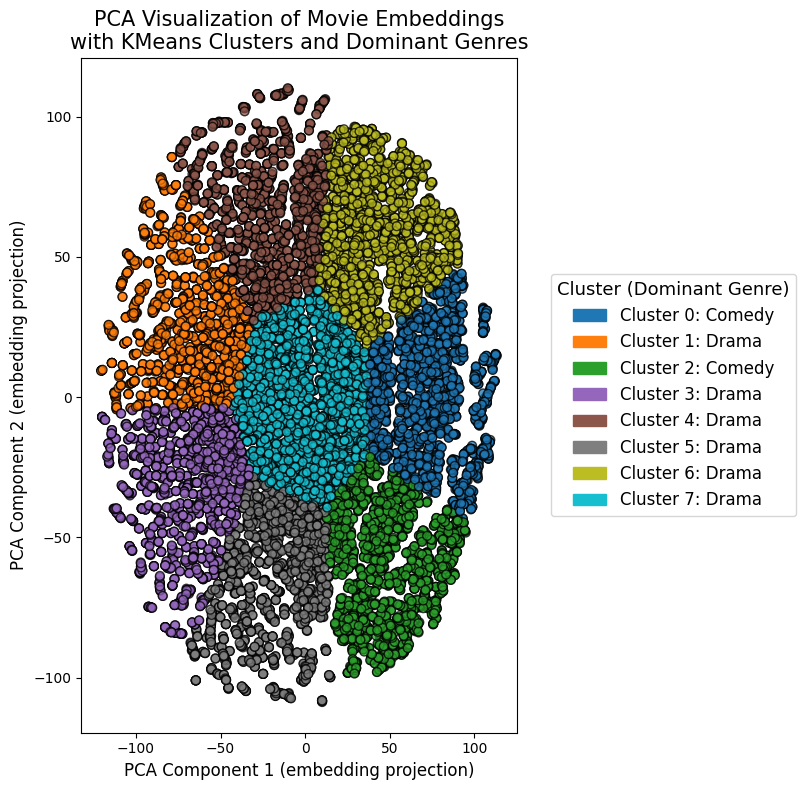

In [31]:
# Plotting a PCA Cluster Visualization for Movie Embeddings.


# --- Cluster color mapping ---
cluster_colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

# Legend handles: show cluster index and its dominant genre
legend_handles = [
    mpatches.Patch(
        color=cluster_colors[i],
        label=f'Cluster {i}: {dominant_genres[i]}'
    )
    for i in range(n_clusters)
]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    movie_emb_2d[:, 0], movie_emb_2d[:, 1],
    c=movie_cluster_labels, cmap='tab10', alpha=0.75, s=40, edgecolor='k'
)

plt.xlabel('PCA Component 1 (embedding projection)', fontsize=12)
plt.ylabel('PCA Component 2 (embedding projection)', fontsize=12)
plt.title('PCA Visualization of Movie Embeddings\nwith KMeans Clusters and Dominant Genres', fontsize=15)

# 
plt.legend(
    handles=legend_handles,
    title='Cluster (Dominant Genre)',
    loc='center left',          # left of the legend at anchor point
    bbox_to_anchor=(1.04, 0.5), # 1.04 = just outside right border; 0.5 = center vertically
    frameon=True,
    borderaxespad=1,
    fontsize=12,
    title_fontsize=13
)

# --- Shrink plot area to leave space for legend on the right ---
plt.tight_layout(rect=[0, 0, 0.83, 1])  # Adjust right edge to leave space

plt.show()

Above is the PCA (Principal Component Analysis) visualization of movie embeddings with each point representing a movie and colored by its assignment to KMeans cluster. The legend links the number of a cluster to its dominant genre (the most common genre, among the cluster’s movies).

# Key details:

Axes: The x-axis and y-axis will correspond to first two PCA components, which explain most of the variation in high-dimensional movie embedding space.

Color: Each cluster(KMeans) is represented by one color. The legend gives us the number of the cluster and a representative genre for the cluster, e.g., “Cluster 3: Action”.

Clustering: Points (i.e., movies) that lie close in this space possess similar embeddings, and hence likely exhibit similar attributes as learned by the model.

Genre-driven clustering: Most clusters are characterized by “Drama” or “Comedy” or “Action". So that means that embedding-and-clustering process is picking up genre as an important axis of similarity between movies.

Overlapping genres: Some clusters share the same towering genre (e.g., multiple clusters are dominated by Drama), so that there must be a finer sub-structure within genres, possibly as a result of sub-genres, style, or other latent features.

Cluster separation: The clusters are distinct by eye, so that embeddings can distinguish between different movie types especially with their genre.

Movie diversity: The presence of clusters with different dominant genres (not all Drama, for instance) shows that the model encodes enough information to differentiate genre preferences.

In [32]:

# 1. Make sure you have your movie embeddings as 2D array:
# movie_emb_2d = ...  # (num_movies, 2)

# 2. Cluster movies with KMeans
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(movie_emb_2d)
cluster_labels = kmeans.labels_  # This is what you need!

# 3. Make a DataFrame mapping each movieId to its cluster
movie_id_list = list(movie_mapping.keys())
cluster_df = pd.DataFrame({
    'movieId': movie_id_list,
    'cluster': cluster_labels
})

# 4. Merge genre info
movie_genre_df = df[['movieId', 'genres']].drop_duplicates()
merged = cluster_df.merge(movie_genre_df, on='movieId')

# 5. Find the most common main genre in each cluster
dominant_genres = []
for cl in range(n_clusters):
    genres = merged[merged['cluster'] == cl]['genres'].dropna().apply(
        lambda g: g.split('|')[0] if g else '(no genres listed)'
    )
    if len(genres) == 0:
        dominant_genres.append('None')
    else:
        dominant_genres.append(genres.value_counts().idxmax())

print("Dominant genres for each cluster:", dominant_genres)


Dominant genres for each cluster: ['Comedy', 'Drama', 'Comedy', 'Drama', 'Drama', 'Drama', 'Drama', 'Drama']


In [33]:

# Get movie embeddings from the model
model.eval()
out = model(data.x_dict, data.edge_index_dict)
movie_emb = out['movie'].detach().cpu().numpy()

# Project movie embeddings to 2D
movie_emb_2d = TSNE(n_components=2, random_state=42, perplexity=5).fit_transform(movie_emb)

# KMeans clustering on movies
n_clusters = 8
movie_kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(movie_emb_2d)
movie_cluster_labels = movie_kmeans.labels_

In [34]:

# Show most common main genre for each cluster

cluster_main_genre = []
for i in range(n_clusters):
    cluster_idx = np.where(cluster_labels == i)[0]
    mids = [list(movie_mapping.keys())[j] for j in cluster_idx]
    main_genres = [filtered_df[filtered_df['movieId'] == mid]['genres'].values[0].split('|')[0] for mid in mids]
    top = pd.Series(main_genres).value_counts().idxmax() if main_genres else "None"
    cluster_main_genre.append(top)
print("Main genre for each cluster:", cluster_main_genre)


Main genre for each cluster: ['Comedy', 'Drama', 'Comedy', 'Drama', 'Drama', 'Drama', 'Drama', 'Drama']


In [35]:
# This assumes you already have a trained model and 'data' object as per your main code
model.eval()
out = model(data.x_dict, data.edge_index_dict)
user_emb = out['user']  # This is a torch.Tensor


In [36]:

# Choose the number of clusters
n_clusters = 8
# If user_emb is a torch tensor, convert to numpy
user_emb_np = user_emb.detach().cpu().numpy() if hasattr(user_emb, 'detach') else np.array(user_emb)

# Project to 2D with PCA
user_emb_2d = PCA(n_components=2).fit_transform(user_emb_np)
# Fit KMeans on your projected embeddings
user_kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(user_emb_2d)
user_cluster_labels = user_kmeans.labels_

In [37]:
user_ids = filtered_df['userId'].unique()
user_activity = np.array([np.sum(filtered_df['userId'] == uid) for uid in user_ids])
user_cluster_df = pd.DataFrame({
    'userId': user_ids,
    'cluster': user_cluster_labels,
    'activity': user_activity
})
print(user_cluster_df.head())


   userId  cluster  activity
0       1        2       141
1       2        1        52
2       3        7       147
3       4        5        27
4       5        1        33


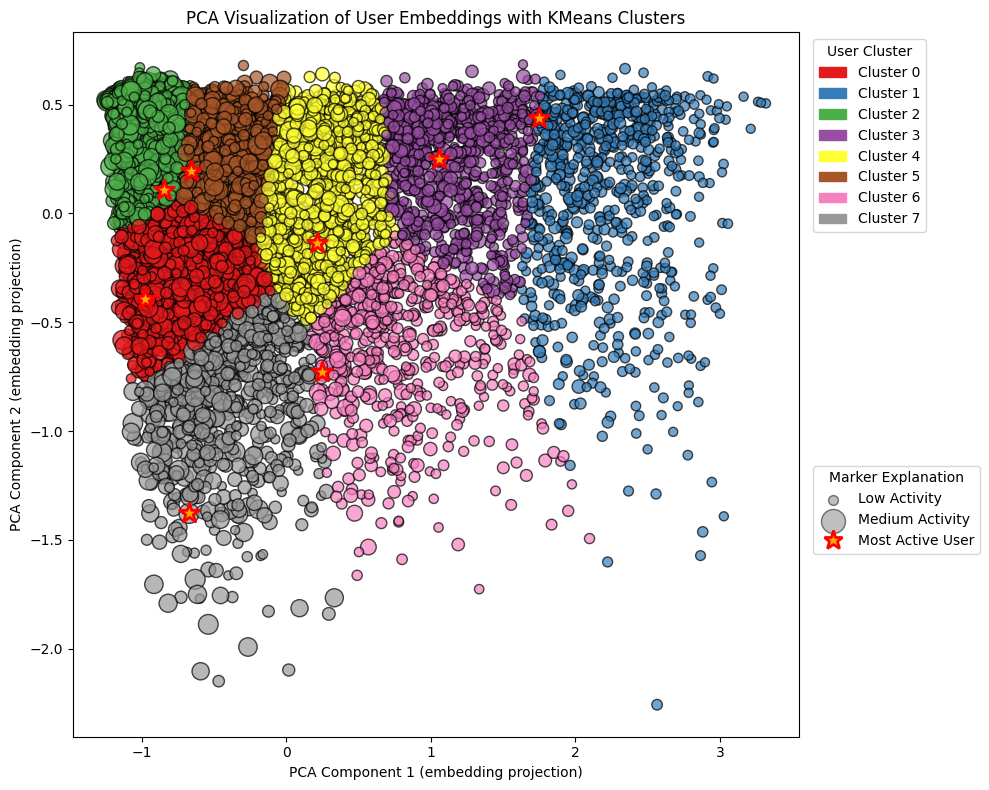

In [38]:
# Plotting a PCA Visualization of User Embeddings with K-Means Clusters.


# ----- Compute 2D PCA projection if not already done -----
# If user_emb is a torch tensor, convert to numpy
user_emb_np = user_emb.detach().cpu().numpy() if hasattr(user_emb, 'detach') else np.array(user_emb)

# Project to 2D with PCA
user_emb_2d = PCA(n_components=2).fit_transform(user_emb_np)

plt.figure(figsize=(10, 8))

# ---- Scatter plot with colored clusters and variable size ----
scatter = plt.scatter(
    user_emb_2d[:, 0], user_emb_2d[:, 1],
    c=user_cluster_labels, cmap='Set1', alpha=0.7,
    s=np.array(user_activity) * 0.6 + 30,
    edgecolor='k'
)

# ---- Highlight most active user per cluster with star ----
for cluster in range(n_clusters):
    cluster_indices = np.where(user_cluster_labels == cluster)[0]
    most_active = cluster_indices[np.argmax(np.array(user_activity)[cluster_indices])]
    plt.scatter(user_emb_2d[most_active, 0], user_emb_2d[most_active, 1],
                c='orange', edgecolor='red', s=220, marker='*', linewidths=2, zorder=10)

# ---- Custom legend handles ----
cluster_colors = plt.cm.Set1(np.linspace(0, 1, n_clusters))
cluster_patches = [
    mpatches.Patch(color=cluster_colors[i], label=f'Cluster {i}')
    for i in range(n_clusters)
]

activity_sizes = [50, 300]
size_labels = ['Low Activity', 'Medium Activity', 'High Activity']
size_handles = [
    plt.scatter([], [], s=s, edgecolor='k', color='gray', alpha=0.5, label=l)
    for s, l in zip(activity_sizes, size_labels)
]

star_handle = mlines.Line2D([], [], color='orange', marker='*', linestyle='None',
                            markeredgecolor='red', markeredgewidth=2,
                            markersize=14, label='Most Active User')

first_legend = plt.legend(handles=cluster_patches, title="User Cluster", loc='upper left', bbox_to_anchor=(1.01, 1.0))
second_legend = plt.legend(handles=size_handles + [star_handle], 
                           title="Marker Explanation", loc='lower left', bbox_to_anchor=(1.01, 0.25))
plt.gca().add_artist(first_legend)

plt.xlabel('PCA Component 1 (embedding projection)')
plt.ylabel('PCA Component 2 (embedding projection)')
plt.title('PCA Visualization of User Embeddings with KMeans Clusters')
plt.tight_layout()
plt.show()


* Each point represents a single user from your dataset, visualized in two dimensions using PCA (Principal Component Analysis), which reduces the complex, high-dimensional user embedding down to 2D for easier visualization.

Color of points: Users are grouped by their assigned KMeans cluster, with each color representing a different cluster (Cluster 0 through Cluster 4).

Size and marker of points:

Small, light grey: Low activity users

Medium, grey: Medium activity users

Large, dark grey: High activity users

Red star: The most active user within each cluster

*The axes ("PCA Component 1/2") do not have specific physical meaning but represent the two directions with the most variation in the user embeddings. Users close together in this plot are similar according to the model.

*This graph effectively visualizes both user segmentation (via clustering) and engagement (via marker size/color/star), helping you understand the diversity in user base and spot patterns that can be useful for personalized recommendations, marketing, or further model improvements.

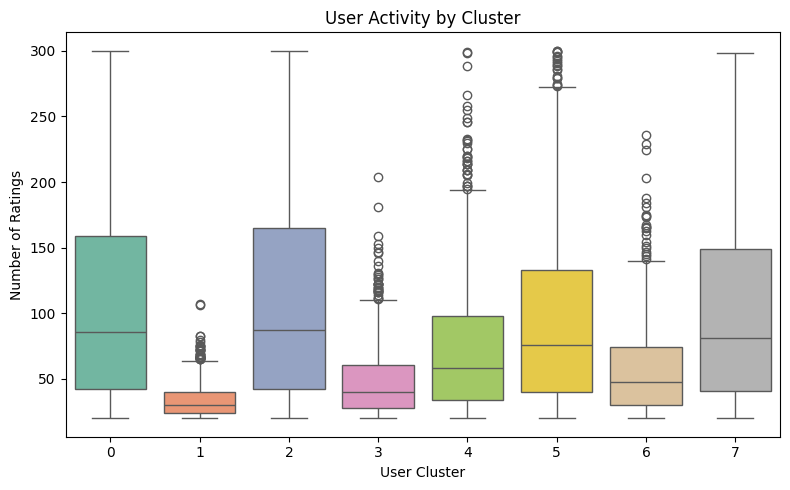

In [39]:

user_activity = np.array([np.sum(filtered_df['userId'] == uid) for uid in user_ids])

user_cluster_df = pd.DataFrame({
    'userId': user_ids,
    'cluster': user_cluster_labels,
    'activity': user_activity
})

plt.figure(figsize=(8,5))
ax = sns.boxplot(
    x='cluster', 
    y='activity', 
    data=user_cluster_df, 
    hue='cluster',            
    palette='Set2', 
    legend=False         
)

# Custom legend remains the same
palette = sns.color_palette('Set2', n_colors=user_cluster_df['cluster'].nunique())
legend_handles = [
    mpatches.Patch(color=palette[i], label=f'Cluster {i}')
    for i in range(user_cluster_df['cluster'].nunique())
]
plt.xlabel('User Cluster')
plt.ylabel('Number of Ratings')
plt.title('User Activity by Cluster')
plt.tight_layout()
plt.show()


* In the above Box-plot, each color corresponds to a user cluster, which is obtained by unsupervised clustering of user behavior. For instance, in the light green box (Cluster 4) we see users who tends to rate the most movies as both their median and range of activity is much larger than the other users, whereas in the yellow box (Cluster 5) we have users with a consistent low level of activity and a wider spread of low level activity outliers. The range and position of each colored box demonstrates how movie rating activity differs between clusters and identities separable groups such as high/low engagement (green/pink, and yellow/blue) users.

In [40]:

movie_id_list = list(movie_mapping.keys())
cluster_df = pd.DataFrame({
    'movieId': movie_id_list,
    'cluster': cluster_labels
})
movie_genre_df = df[['movieId', 'genres']].drop_duplicates()
merged = cluster_df.merge(movie_genre_df, on='movieId').copy()

dominant_genres = []
for cl in range(n_clusters):
    genres = merged[merged['cluster'] == cl]['genres'].dropna().apply(lambda g: g.split('|')[0] if g else '(no genres listed)')
    if len(genres) == 0:
        dominant_genres.append('None')
    else:
        dominant_genres.append(genres.value_counts().idxmax())

# Show the dominant genre for each cluster
for i, genre in enumerate(dominant_genres):
    print(f"Cluster {i}: {genre}")


Cluster 0: Comedy
Cluster 1: Drama
Cluster 2: Comedy
Cluster 3: Drama
Cluster 4: Drama
Cluster 5: Drama
Cluster 6: Drama
Cluster 7: Drama


In [41]:

movie_id_list = list(movie_mapping.keys())
cluster_df = pd.DataFrame({
    'movieId': movie_id_list,
    'cluster': cluster_labels
})
# Merge genre info
movie_genre_df = df[['movieId', 'genres']].drop_duplicates()
merged = cluster_df.merge(movie_genre_df, on='movieId')

# Find the most common main genre in each cluster
dominant_genres = []
for cl in range(n_clusters):
    genres = merged[merged['cluster'] == cl]['genres'].dropna().apply(lambda g: g.split('|')[0] if g else '(no genres listed)')
    if len(genres) == 0:
        dominant_genres.append('None')
    else:
        dominant_genres.append(genres.value_counts().idxmax())


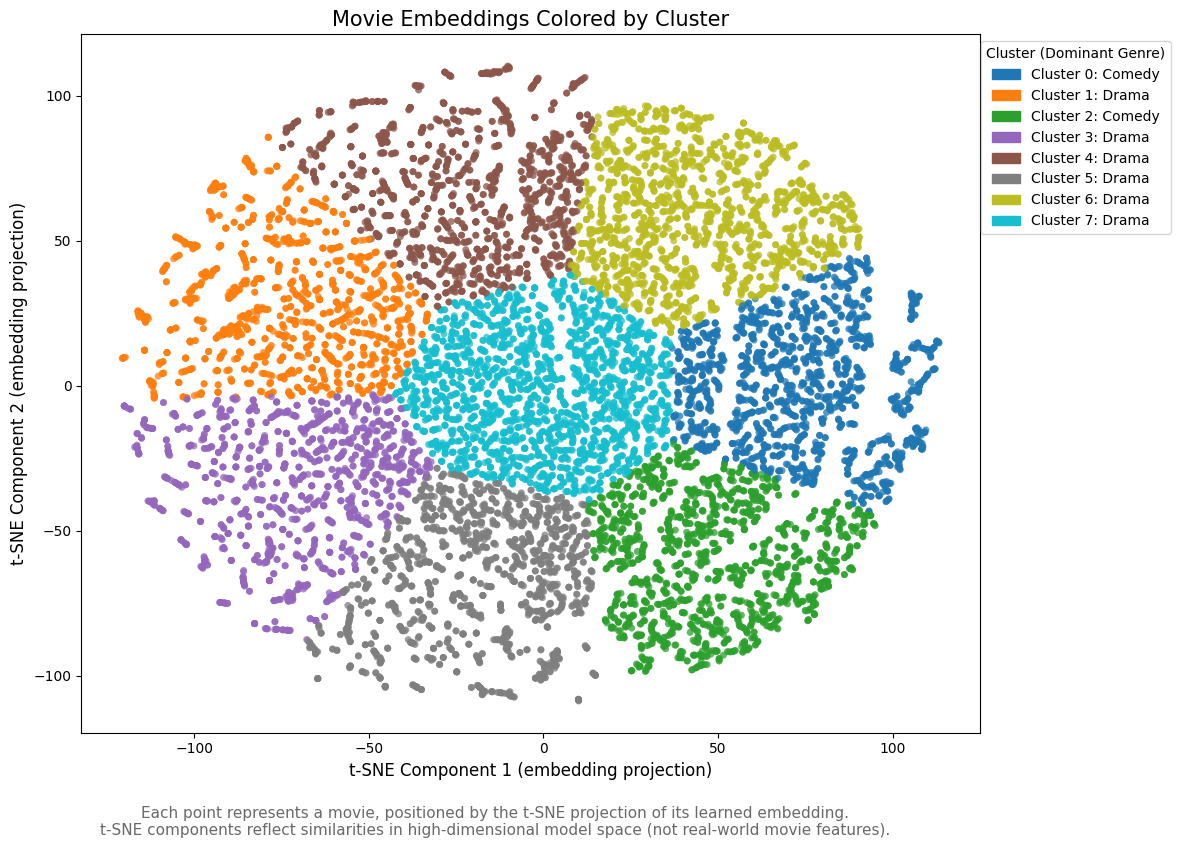

In [42]:

cluster_colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
legend_handles = [
    mpatches.Patch(color=cluster_colors[i], label=f'Cluster {i}: {dominant_genres[i]}')
    for i in range(n_clusters)
]

plt.figure(figsize=(10,8))
plt.scatter(
    movie_emb_2d[:,0], movie_emb_2d[:,1],
    c=cluster_labels, cmap='tab10', alpha=0.75, s=25, edgecolor='none'
)
plt.title("Movie Embeddings Colored by Cluster", fontsize=15)
plt.xlabel("t-SNE Component 1 (embedding projection)", fontsize=12)
plt.ylabel("t-SNE Component 2 (embedding projection)", fontsize=12)
plt.tight_layout()
plt.figtext(
    0.5, -0.05,
    "Each point represents a movie, positioned by the t-SNE projection of its learned embedding.\n"
    "t-SNE components reflect similarities in high-dimensional model space (not real-world movie features).",
    ha="center", fontsize=11, color='dimgray'
)
plt.legend(handles=legend_handles, title='Cluster (Dominant Genre)', loc='upper right', bbox_to_anchor=(1.22, 1))
plt.show()


* The above scatterplot shows the 2-d movie embeddings obtained by applying the t-SNE algorithm, originally designed to visualize complex data in lower dimensions, we have previously reduced the dimensionality of this feature spaceality to 2. Each point on the axis represents a specific movie, and points placed near to each other are closer in their learned features (although in many cases, not in their actual genre or metadata).

* Colours represent the clusters found with KMeans clustering, and the clusters are identified in the legend using its label number and main genre. For instance, "Cluster 0: Action" would show that most movies within that cluster are classified as Action.
# Key points:

* Feature Similarity Clustering: The clear separation of movies into clusters of color clouds indicates that the model’s embeddings are encoding some meaningful notion of similarity; that is, movies within the same cluster tend to have something in common, be it some property or some viewing audience.

* Genre Patterns: Several clusters are dominated by genres (e.g., Drama; Comedy) which suggests that the embedding captures genre specific information. For example: the Clusters 1, 5, 6, and 7 are all of Drama genre dominated, indicating that Drama movies are broad and can be clustered in many different ways.

* Overlapping & Borders: There is some degree of overlaps or borders between clusters, indicating the overlaps among some genres, or the border movies that are similar to the cluster centers of neighbour clusters.

* Interpretation: The t-SNE axes themselves (Component 1 and 2) don’t have some real-world interpretation but the relative position and cluster separation to other movies tells you how well your learned representation separates concepts in movies.

* This figure illustrates that the learned movie embeddings contain rich information about movie genres and similarities and can effectively group movies into meaningful genre-related clusters. It’s much more power validation of how good your model’s extracted representation is.

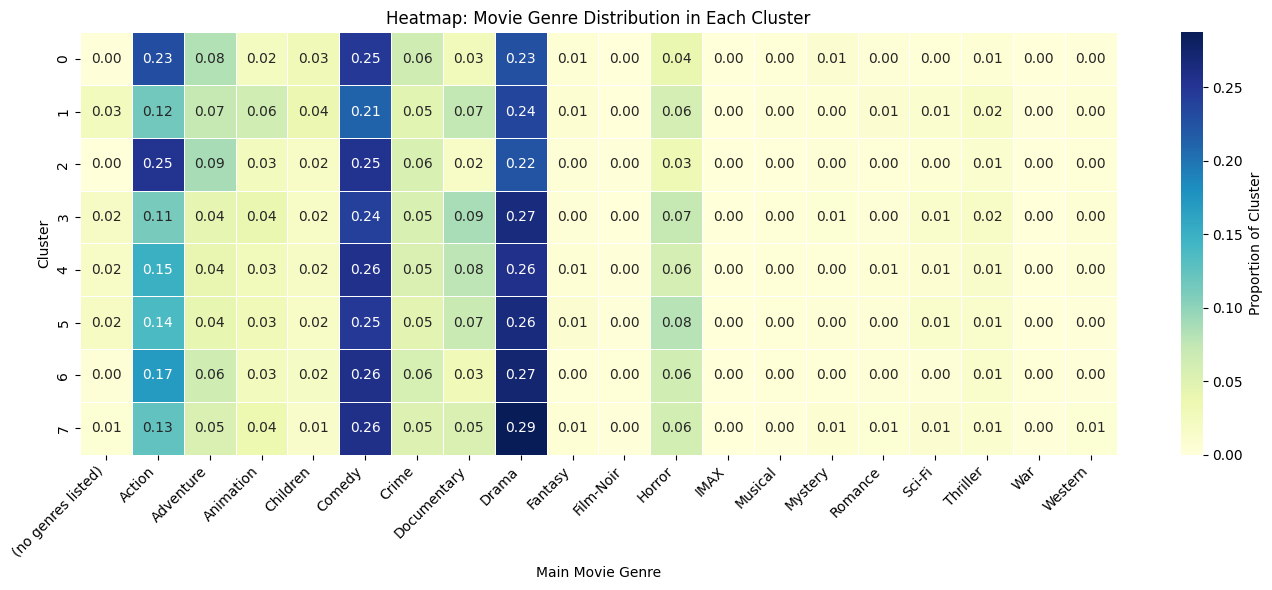

Dominant genre for each cluster:
cluster
0    Comedy
1     Drama
2    Comedy
3     Drama
4     Drama
5     Drama
6     Drama
7     Drama
dtype: object


In [43]:

# 1. Extract main genre
merged['main_genre'] = merged['genres'].fillna('(no genres listed)').apply(lambda x: x.split('|')[0] if x else '(no genres listed)')

# 2. Count genres per cluster
genre_counts = merged.groupby(['cluster', 'main_genre']).size().reset_index(name='count')

# 3. Pivot to Cluster x Genre matrix
genre_pivot = genre_counts.pivot(index='cluster', columns='main_genre', values='count').fillna(0)

# 4. Normalize (row-wise: within each cluster)
genre_pivot_norm = genre_pivot.div(genre_pivot.sum(axis=1), axis=0)

# 5. Plot the heatmap
plt.figure(figsize=(14,6))
sns.heatmap(
    genre_pivot_norm,
    cmap='YlGnBu',
    annot=True, fmt='.2f',
    linewidths=.5,
    cbar_kws={'label': 'Proportion of Cluster'}
)
plt.xlabel('Main Movie Genre')
plt.ylabel('Cluster')
plt.title('Heatmap: Movie Genre Distribution in Each Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 6. Print dominant genre per cluster
print("Dominant genre for each cluster:")
print(genre_pivot_norm.idxmax(axis=1))


* The above heatmap displays how the main movie genres are distributed in each cluster of movies you formed with your embedding and clustering. 
Each row is a cluster, each column corresponds to a movie genre. 
The color intensity (and the number displayed) represents the percentage of movies in that cluster that are in each genre 
(higher numbers, stronger effect).

From the heatmap, what we observe is that:

The largest proportion of DRAMA in most clusters (1,5,6,7 and other) are dominant across any other genres (from 0.25 to 0.28).

Comedy is the predominant genre in some clusters (notably for clusters 1, 2 and 3) whose proportion is greater than that of other genre.

In some clusters, Action and Adventure are also visibly reflecting, but still not overwhelmingly.

Most of the genres have low and very low percentages in each cluster, which means that on the other hand, 
clusters are focusing on a limited number of genres instead of being mixed.



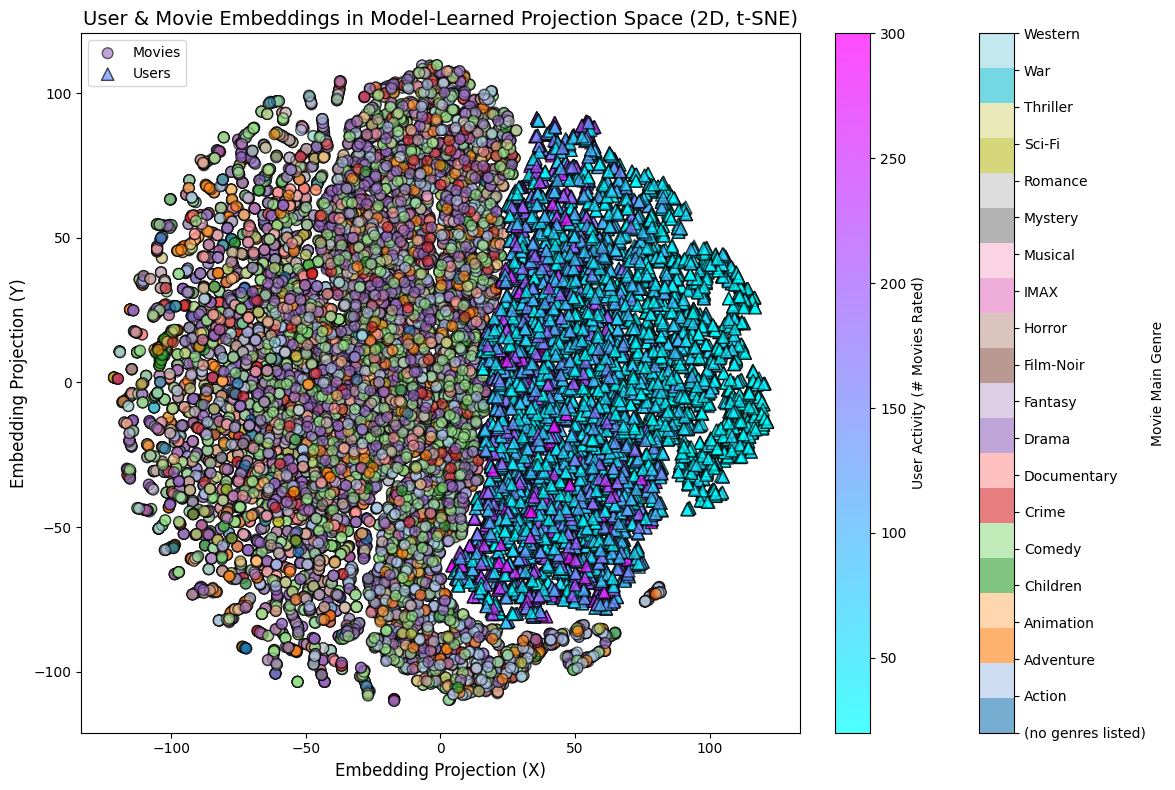

In [44]:
# Plotting a User & Movie Embeddings in Model-Learned Projection Space (2D, t-SNE).

# 1. Get embeddings from your trained model
model.eval()
out = model(data.x_dict, data.edge_index_dict)
user_emb = out['user'].detach().cpu().numpy()
movie_emb = out['movie'].detach().cpu().numpy()

# 2. Stack all embeddings for joint visualization
all_emb = np.vstack([user_emb, movie_emb])

# 3. Reduce to 2D with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
all_emb_2d = tsne.fit_transform(all_emb)
user_emb_2d = all_emb_2d[:user_emb.shape[0]]
movie_emb_2d = all_emb_2d[user_emb.shape[0]:]

# 4. For color: movies by main genre, users by activity (number of ratings)
genres_main = []
for mid in movie_mapping:
    genres = df[df['movieId'] == mid]['genres'].values[0].split('|')
    genres_main.append(genres[0] if genres else '(no genres listed)')
unique_genres = sorted(set(genres_main))
genre_colors = {g: i for i, g in enumerate(unique_genres)}
movie_colors = [genre_colors[g] for g in genres_main]

# Users: color by activity (number of ratings)
user_activity = [np.sum(src == i) for i in range(user_emb.shape[0])]

# 5. Plot!
plt.figure(figsize=(12, 8))

# Movies: colored by genre
scatter1 = plt.scatter(
    movie_emb_2d[:, 0], movie_emb_2d[:, 1],
    c=movie_colors, cmap='tab20', alpha=0.6,
    label="Movies", s=60, marker='o', edgecolor='k'
)

# Users: colored by activity
scatter2 = plt.scatter(
    user_emb_2d[:, 0], user_emb_2d[:, 1],
    c=user_activity, cmap='cool', alpha=0.7,
    label="Users", s=80, marker='^', edgecolor='k'
)

# Movie genre colorbar
cbar1 = plt.colorbar(scatter1, ticks=range(len(unique_genres)), pad=0.01)
cbar1.ax.set_yticklabels(unique_genres)
cbar1.set_label('Movie Main Genre')

# User activity colorbar
cbar2 = plt.colorbar(scatter2, pad=0.04)
cbar2.set_label('User Activity (# Movies Rated)')

plt.legend(["Movies", "Users"], loc='upper left')
plt.title("User & Movie Embeddings in Model-Learned Projection Space (2D, t-SNE)", fontsize=14)

# Updated axis labels!
plt.xlabel("Embedding Projection (X)", fontsize=12)
plt.ylabel("Embedding Projection (Y)", fontsize=12)

plt.tight_layout()
plt.show()

The above plot shows both the user and movie embeddings in 2D as learnt by the model, t-SNE is used to reduce the number of dimensions.

Movies are denoted by colored circles, where each color is a different movie genre (right legend).

Users are represented as triangles colored according to their level of activity (number of rated movies) in the colorbar (from blue meaning low activity to pink for high).

# Insights:

Movies within the same style or genre can be seen to be clustered in the plot and we observe that our embedding captures genre very well. It can be seen as regions of similar-color sharing circles.

User triangles can be often found close to a dense area of movie points. The user heatmap reveals a kind of color gradient among users: the peak-around-pink-colored areas cover larger space, meaning, the more active users residing there might have more diverse taste, and the blue ones apparently are closer to some genres.

It also reveals the relationship between users and movies: users attached to particular genre cluster may also tend to prefer these cluster related genres.

In [45]:
#Compare Clusters to Real Genres
#This means GNN is learning to embed movies so that movies of similar genres are closer together— and t-SNE  confirms this!

# For each cluster, show the most common genre
cluster_genres = pd.DataFrame({'cluster': cluster_labels, 'genre': genres_main})
for cl in range(n_clusters):
    genres_in_cluster = cluster_genres[cluster_genres['cluster'] == cl]['genre']
    most_common = genres_in_cluster.value_counts().head(3)
    print(f"Cluster {cl}:")
    print(most_common)
    print('-'*20)

Cluster 0:
genre
Comedy    474
Action    439
Drama     434
Name: count, dtype: int64
--------------------
Cluster 1:
genre
Drama     398
Comedy    356
Action    194
Name: count, dtype: int64
--------------------
Cluster 2:
genre
Comedy    472
Action    469
Drama     415
Name: count, dtype: int64
--------------------
Cluster 3:
genre
Drama     435
Comedy    394
Action    182
Name: count, dtype: int64
--------------------
Cluster 4:
genre
Drama     444
Comedy    443
Action    259
Name: count, dtype: int64
--------------------
Cluster 5:
genre
Drama     445
Comedy    416
Action    230
Name: count, dtype: int64
--------------------
Cluster 6:
genre
Drama     560
Comedy    527
Action    347
Name: count, dtype: int64
--------------------
Cluster 7:
genre
Drama     737
Comedy    660
Action    321
Name: count, dtype: int64
--------------------


Cluster 0 (n=1913):
  Comedy                 474 ( 24.8%)
  Action                 439 ( 22.9%)
  Drama                  434 ( 22.7%)
  Adventure              157 (  8.2%)
  Crime                  124 (  6.5%)
----------------------------


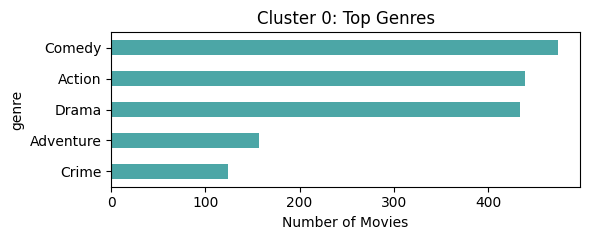

Cluster 1 (n=1684):
  Drama                  398 ( 23.6%)
  Comedy                 356 ( 21.1%)
  Action                 194 ( 11.5%)
  Documentary            124 (  7.4%)
  Adventure              122 (  7.2%)
----------------------------


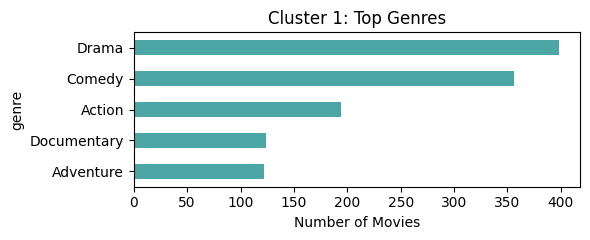

Cluster 2 (n=1854):
  Comedy                 472 ( 25.5%)
  Action                 469 ( 25.3%)
  Drama                  415 ( 22.4%)
  Adventure              163 (  8.8%)
  Crime                  104 (  5.6%)
----------------------------


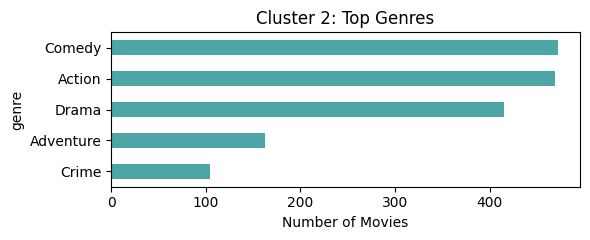

Cluster 3 (n=1637):
  Drama                  435 ( 26.6%)
  Comedy                 394 ( 24.1%)
  Action                 182 ( 11.1%)
  Documentary            142 (  8.7%)
  Horror                 118 (  7.2%)
----------------------------


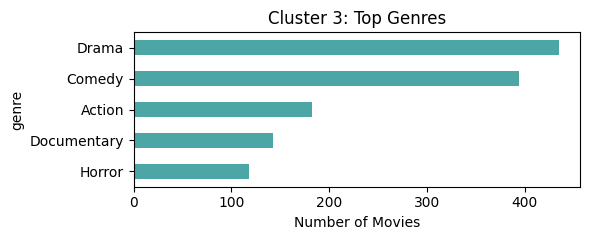

Cluster 4 (n=1731):
  Drama                  444 ( 25.6%)
  Comedy                 443 ( 25.6%)
  Action                 259 ( 15.0%)
  Documentary            134 (  7.7%)
  Horror                 103 (  6.0%)
----------------------------


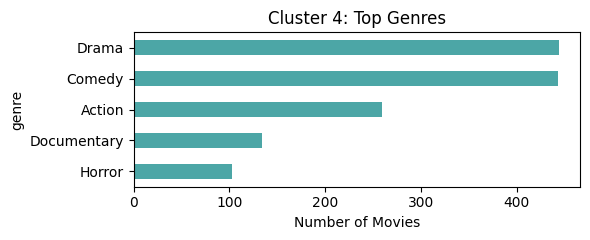

Cluster 5 (n=1680):
  Drama                  445 ( 26.5%)
  Comedy                 416 ( 24.8%)
  Action                 230 ( 13.7%)
  Horror                 134 (  8.0%)
  Documentary            116 (  6.9%)
----------------------------


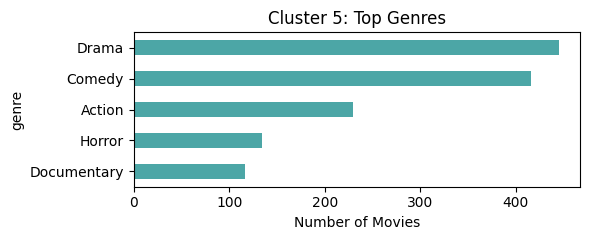

Cluster 6 (n=2048):
  Drama                  560 ( 27.3%)
  Comedy                 527 ( 25.7%)
  Action                 347 ( 16.9%)
  Adventure              131 (  6.4%)
  Horror                 129 (  6.3%)
----------------------------


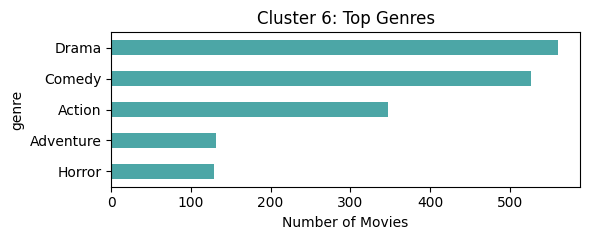

Cluster 7 (n=2566):
  Drama                  737 ( 28.7%)
  Comedy                 660 ( 25.7%)
  Action                 321 ( 12.5%)
  Horror                 158 (  6.2%)
  Documentary            141 (  5.5%)
----------------------------


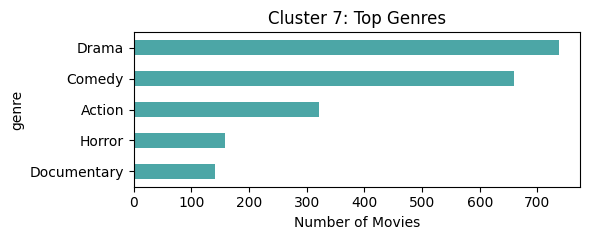

In [46]:

# DataFrame of movie cluster assignments and genres
cluster_genres = pd.DataFrame({'cluster': cluster_labels, 'genre': genres_main})

for cl in range(n_clusters):
    genres_in_cluster = cluster_genres[cluster_genres['cluster'] == cl]['genre']
    most_common = genres_in_cluster.value_counts().head(5)
    most_common_pct = 100 * most_common / genres_in_cluster.shape[0]
    print(f"Cluster {cl} (n={len(genres_in_cluster)}):")
    for genre, count in most_common.items():
        pct = most_common_pct[genre]
        print(f"  {genre:<20} {count:>5} ({pct:>5.1f}%)")
    print('-'*28)
    
    # Optional: bar plot for the top genres in this cluster
    plt.figure(figsize=(6,2.5))
    most_common.iloc[::-1].plot(kind='barh', color='teal', alpha=0.7)
    plt.title(f"Cluster {cl}: Top Genres")
    plt.xlabel("Number of Movies")
    plt.tight_layout()
    plt.show()


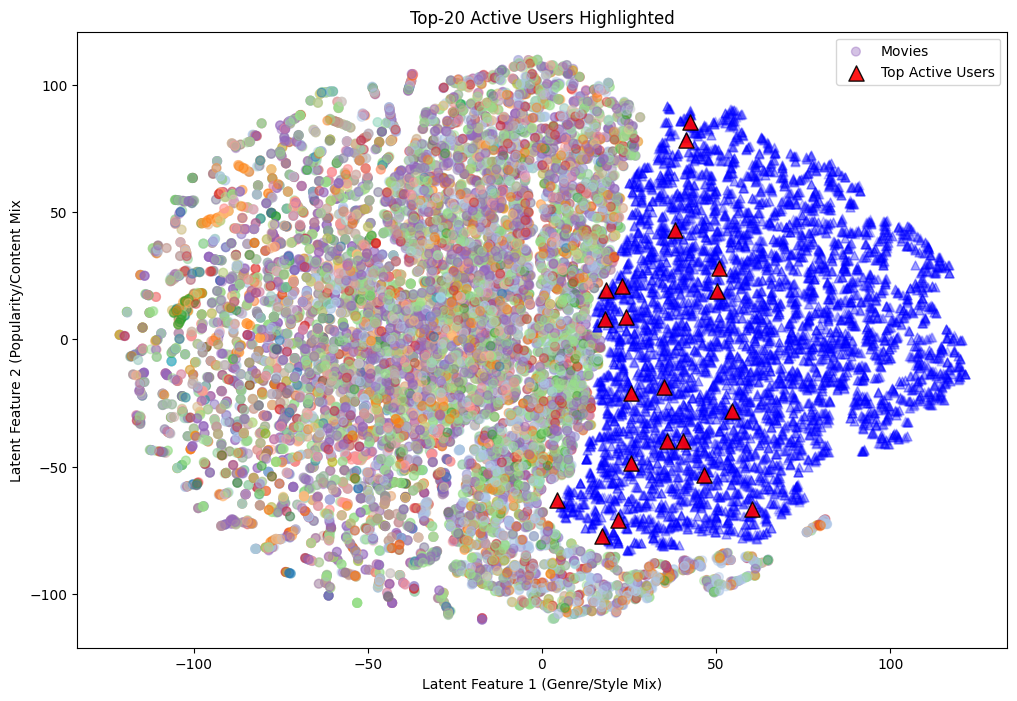

In [47]:
#Show Only Top-N Active Users

N = 20  # Number of top users to highlight
top_user_indices = np.argsort(user_activity)[-N:]

plt.figure(figsize=(12,8))

# Plot all movies as background
plt.scatter(movie_emb_2d[:, 0], movie_emb_2d[:, 1], c=movie_colors, cmap='tab20', alpha=0.4, s=40, marker='o', label='Movies')

# Plot all users (light)
plt.scatter(user_emb_2d[:, 0], user_emb_2d[:, 1], c='blue', alpha=0.2, s=40, marker='^')

# Highlight top-N active users
plt.scatter(user_emb_2d[top_user_indices, 0], user_emb_2d[top_user_indices, 1],
            c='red', alpha=0.9, s=120, marker='^', label='Top Active Users', edgecolor='k')

plt.legend()
plt.title(f"Top-{N} Active Users Highlighted")
plt.xlabel("Latent Feature 1 (Genre/Style Mix)"); plt.ylabel("Latent Feature 2 (Popularity/Content Mix")
plt.show()

The above scatter plot represents the learned embedding space of movies and users in a Recommender System. Each point is a movie or user (movie is a coloured circle, user is a blue triangle), and the x and y values are down-projected from higher dimensional embeddings to two “latent” features—Latent Feature 1 (Genre/Style Mix) and Latent Feature 2 (Popularity/Content Mix): These axes represent latent structure or preferences that the model has learned (groups of similar genres, of user behaviors).
# Key points:

* Movies are displayed as colored discs, with colors corresponding to genres or other clusters.

* Users are represented as the blue triangles that are spread out in the embedding space based on their learned preferences and relations for movies.

* Of the Active Users featured on the red triangle and black border. These are the users that have the most number of ratings in the dataset and are, therefore, the most active users.

# Interpretation: 

*The positioning of users and movies in this space reflects how the model groups similar movies and users together based on patterns in the data. For example, movies of similar genres or popularity are placed closer together, and users with similar viewing patterns are also positioned nearby.

* This particular region of the embedding space contains the top-20 active users. This might point to the fact that users with high activity have something in common or broader preferences that build up denser regions in recommendation space.

* The two axes are abstract; they can be seen as mixture of genre, style, popularity and possibly other content-related properties. These clusters and distribution patterns can tell whether the model is able to separate those different types of movies and users efficiently.

In [48]:
# Get the userId values of your top-N active users

top_user_ids = [list(user_mapping.keys())[i] for i in top_user_indices]

for uid in top_user_ids:
    user_ratings = df[df['userId'] == uid]
    movie_genres = user_ratings['genres']
    genres_flat = [g for genres in movie_genres for g in genres.split('|') if g]
    genre_counts = pd.Series(genres_flat).value_counts().head(5)
    print(f"Top genres for user {uid}:")
    print(genre_counts)
    print('-' * 20)

Top genres for user 387:
Comedy       130
Drama        105
Action        98
Adventure     91
Romance       90
Name: count, dtype: int64
--------------------
Top genres for user 3436:
Drama        130
Comedy       118
Action        82
Adventure     81
Romance       77
Name: count, dtype: int64
--------------------
Top genres for user 3319:
Drama       204
Thriller     82
Crime        57
Mystery      47
Romance      40
Name: count, dtype: int64
--------------------
Top genres for user 3263:
Action       233
Adventure    143
Thriller     119
Sci-Fi        88
Drama         72
Name: count, dtype: int64
--------------------
Top genres for user 7680:
Comedy      177
Drama       154
Romance      90
Fantasy      41
Thriller     37
Name: count, dtype: int64
--------------------
Top genres for user 4507:
Action       143
Thriller     118
Sci-Fi       115
Adventure    100
Drama         94
Name: count, dtype: int64
--------------------
Top genres for user 410:
Comedy       168
Adventure    125
Chil

In [49]:
# Display each top user for a specific Cluster.

for idx in top_user_indices:
    uid = list(user_mapping.keys())[idx]
    cl = user_cluster_labels[idx]
    print(f"Top user {uid} (index {idx}) belongs to User Cluster {cl}")

Top user 387 (index 335) belongs to User Cluster 0
Top user 3436 (index 2992) belongs to User Cluster 0
Top user 3319 (index 2890) belongs to User Cluster 2
Top user 3263 (index 2838) belongs to User Cluster 7
Top user 7680 (index 6699) belongs to User Cluster 2
Top user 4507 (index 3933) belongs to User Cluster 4
Top user 410 (index 355) belongs to User Cluster 7
Top user 1193 (index 1036) belongs to User Cluster 2
Top user 3068 (index 2666) belongs to User Cluster 5
Top user 6672 (index 5818) belongs to User Cluster 5
Top user 4262 (index 3719) belongs to User Cluster 4
Top user 7415 (index 6464) belongs to User Cluster 2
Top user 9241 (index 8055) belongs to User Cluster 2
Top user 1819 (index 1579) belongs to User Cluster 0
Top user 1016 (index 881) belongs to User Cluster 5
Top user 417 (index 362) belongs to User Cluster 0
Top user 545 (index 473) belongs to User Cluster 2
Top user 4575 (index 3995) belongs to User Cluster 2
Top user 4622 (index 4038) belongs to User Cluster 0
To

In [50]:
# Display the most similar movie indices and movie IDs.

movie_idx = 0
sims = cosine_similarity([movie_emb_2d[movie_idx]], movie_emb_2d)[0]
nearest = np.argsort(sims)[::-1][1:6]  # 5 most similar, not counting itself

nearest_movie_ids = [list(movie_mapping.keys())[i] for i in nearest]
print(f"Most similar movie indices to {movie_idx}: {nearest}")
print(f"Most similar movie IDs: {nearest_movie_ids}")

Most similar movie indices to 0: [257 586  64 152 610]
Most similar movie IDs: [np.int64(3578), np.int64(6874), np.int64(1221), np.int64(225), np.int64(33794)]


In [51]:
# Display the total number of user and movie nodes.

print("Number of user nodes:", data['user'].num_nodes)
print("Number of movie nodes:", data['movie'].num_nodes)

Number of user nodes: 8732
Number of movie nodes: 15113


In [52]:
# Display the Model Summary.

display(HTML("<style>.jp-OutputArea {max-width: 100% !important;}</style>"))

summary(
    model,
    input_data=(train_data.x_dict, train_data.edge_index_dict),
    col_names=["input_size", "output_size", "num_params", "mult_adds"],
    depth=3  
)


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Mult-Adds
RecommenderGNN                                [8732, 82]                [8732, 82]                --                        --
├─HeteroConv: 1-1                             [8732, 82]                [8732, 82]                --                        --
│    └─ModuleDict: 2-1                        --                        --                        --                        --
│    │    └─SAGEConv: 3-1                     [8732, 82]                [15113, 82]               13,530                    204,478,890
│    │    └─SAGEConv: 3-2                     [15113, 82]               [8732, 82]                13,530                    118,143,960
├─Dropout: 1-2                                [15113, 82]               [15113, 82]               --                        --
├─Dropout: 1-3                                [8732, 82]                [8732, 82]    